In [18]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import scipy as sp
import time

# JUST_ABOVE_ONE = 1.00000001 # np.random high arg is exclusive
JUST_ABOVE_ONE = np.nextafter(1.0, np.inf) # np.random high arg is exclusive
JUST_BELOW_ZERO = np.nextafter(0.0, -np.inf) # np.random low arg is inclusive

In [19]:
def isotropic_direction_distribution(number_of_particles=1):
    distribution = np.cos(np.pi * np.random.uniform(low=0, high=JUST_ABOVE_ONE, size=number_of_particles))
    if number_of_particles == 1:
        return distribution[0]
    return distribution

class Surface:
    def __init__(self, id, location):
        self.id = id
        self.location = location
        
        self.number_of_particles_passing_pos = 0
        self.number_of_particles_passing_neg = 0
        
    def pos_particle_pass(self):
        self.number_of_particles_passing_pos += 1
        
    def neg_particle_pass(self):
        self.number_of_particles_passing_neg += 1

class Material:
    def __init__(self, volumetric_source=0, sigma_total=1, sigma_scatter=0):
        self.volumetric_source = volumetric_source
        self.sigma_total = sigma_total
        self.sigma_scatter = sigma_scatter
        self.sigma_absorb = sigma_total - sigma_scatter
        
    def interaction_type(self):
        return np.random.choice(
            ["scatter", "absorb"],
            p=[self.sigma_scatter/self.sigma_total, self.sigma_absorb/self.sigma_total]
        )


class Cell:
    def __init__(self, id, width, material: Material, left_surface : Surface, right_surface : Surface):
        self.id = id
        self.width = width
        self.material = material
        self.left_surface = left_surface
        self.right_surface = right_surface
        
        self.neutron_histories = 0
        self.interaction_tally = 0
        self.absorption_tally = 0
        self.scattering_tally = 0
        self.track_length_tally = 0   
        
    def add_neutron_history(self):
        self.neutron_histories += 1
        
    def scatter(self):
        self.scattering_tally += 1
        self.interaction_tally += 1
        
    def absorb(self):
        self.absorption_tally += 1
        self.interaction_tally += 1
        
    def add_track_length(self, track_length):
        self.add_neutron_history()
        self.track_length_tally += abs(track_length)


class Mesh:
    def __init__(self, problem_width, num_cells, material : Material):
        """Assuming uniform material and uniform cell spacing"""
        self.problem_width = problem_width
        self.num_cells = num_cells
        self.num_surfaces = num_cells + 1
        self.cell_width = problem_width / num_cells
        self.material = material

        self.surfaces = [Surface(i, i * self.cell_width) for i in range(self.num_surfaces)]        
        self.cells = [Cell(i, self.cell_width, material, self.surfaces[i], self.surfaces[i+1]) for i in range(self.num_cells)]
        
    def get_cell(self, position):
        cell_id = int(position / self.cell_width) # floor
        if cell_id == self.num_cells:
            return self.cells[-1]
        return self.cells[cell_id]
    
    def get_surface_x_positions(self):
        return np.array([surface.location for surface in self.surfaces])
    
    def get_cell_x_positions(self):
        half_width = self.cell_width / 2
        return np.array([cell.left_surface.location + half_width for cell in self.cells])
    
    def get_absorption_tally(self):
        return np.array([cell.absorption_tally for cell in self.cells])
    
    def get_total_collision_tally(self):
        return np.array([cell.interaction_tally for cell in self.cells])
    
    def get_scalar_flux_collision_tally(self, number_of_particles):
        return np.array([cell.interaction_tally / cell.material.sigma_total / cell.width for cell in self.cells]) / number_of_particles
        # return np.array([cell.interaction_tally for cell in self.cells]) / number_of_particles
    
    def get_scalar_flux_track_length_tally(self, number_of_particles):
        return np.array([cell.track_length_tally / cell.width for cell in self.cells]) / number_of_particles
    
    def get_current_tally(self, number_of_particles):
        return np.array([surface.number_of_particles_passing_pos - surface.number_of_particles_passing_neg for surface in self.surfaces]) / number_of_particles
    

class Source:
    def __init__(self, number_of_particles):
        self.number_of_particles = number_of_particles
        
    def direction_distribution(self):
        raise NotImplementedError
    
    def location_distribution(self):
        raise NotImplementedError

class UniformSurfaceSource(Source):
    def __init__(self, number_of_particles, location=0, direction=1):
        super().__init__(number_of_particles)
        self.location = location
        self.direction = direction
        
    def direction_distribution(self):
        return np.full(self.number_of_particles, self.direction)
    
    def location_distribution(self):
        return np.full(self.number_of_particles, self.location)

class IsotropicVolumetricSource(Source):
    def __init__(self, number_of_particles, location_min=0, location_max=1):
        super().__init__(number_of_particles)
        self.location_min = location_min
        self.location_max = location_max

    def direction_distribution(self):
        return isotropic_direction_distribution(self.number_of_particles)

    def location_distribution(self):
        return np.random.uniform(low=self.location_min, high=self.location_max, size=self.number_of_particles)
    
class IsotropicSurfaceSource(Source):
    def __init__(self, number_of_particles, location=0):
        super().__init__(number_of_particles)
        self.location = location
        
    def direction_distribution(self):
        return isotropic_direction_distribution(self.number_of_particles)
    
    def location_distribution(self):
        return np.full(self.number_of_particles, self.location)


class MonteCarlo():
    def __init__(self, sources: list[Source], mesh : Mesh, left_boundary=None, right_boundary=None):
        """
        • A mesh to compute the spatial distribution of the scalar flux and
        reaction rates
        • A collision to compute the reaction rates then derive the scalar
        flux from it.
        • A surface tally to compute the current at the right and left sur-
        faces of the problem
        • A track-length tally to compute the scalar flux in every mesh
        cell.
        """
        self.sources : list[Source] = sources
        self.mesh : Mesh = mesh

        assert (
            left_boundary is None or left_boundary == "reflecting"
        ), "left_boundary must be none or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            right_boundary is None or right_boundary == "reflecting"
        ), "right_boundary must be none or 'reflecting'"
        self.right_boundary = right_boundary

        self.max_cell_transfers = 1000_000
        self.max_interactions = 1000_000

        self.particle_exits_left = 0
        self.particle_exits_right = 0

    def simulate_particle_to_interaction(self, position, direction):
        """Simulate a particle until it reaches an interaction or leaves the system

        Args:
            position (_type_): x location of the particle
            direction (_type_): cosine of the angle of the particle (positive is right, negative is left)
        """

        number_of_mean_free_paths_remaining = -np.log(np.random.uniform(low=0, high=JUST_ABOVE_ONE))        
        current_x_position = position
        current_cell = self.mesh.get_cell(current_x_position)
        
        for i in range(self.max_cell_transfers):
            if i == self.max_cell_transfers-1:
                raise Exception("Max cell transfers reached")

            distance_traveled_in_infinite_material = number_of_mean_free_paths_remaining / current_cell.material.sigma_total
            x_distance_traveled_in_infinite_material = distance_traveled_in_infinite_material * direction

            if direction >= 0:
                # greater than or equal since if it is zero its just not going to reach anyways
                next_surface = current_cell.right_surface
            elif direction < 0:
                next_surface = current_cell.left_surface

            x_distance_to_next_surface = next_surface.location - current_x_position

            if abs(x_distance_to_next_surface) < abs(x_distance_traveled_in_infinite_material):
                # Particle reaches the next surface before interacting with the material
                distanced_traveled_to_next_surface = x_distance_to_next_surface / direction
                # current_cell.add_track_length(distanced_traveled_to_next_surface)
                current_cell.add_track_length(abs(distanced_traveled_to_next_surface))

                number_of_mean_free_paths_remaining -= abs(distanced_traveled_to_next_surface) * current_cell.material.sigma_total
                assert number_of_mean_free_paths_remaining >= 0, "Number of mean free paths remaining cannot be negative"
                # current_x_position += x_distance_to_next_surface
                current_x_position = next_surface.location
                # particle has not had an interaction, so don't update angle

                if current_x_position <= 0:
                    # Particle leaves the system 
                    next_surface.neg_particle_pass()
                    if self.left_boundary == "reflecting":
                        direction = -direction
                        # current_x_position *= -1
                        continue
                    else:
                        break
                elif current_x_position >= self.mesh.problem_width:
                    # Particle leaves the system
                    next_surface.pos_particle_pass()
                    if self.right_boundary == "reflecting":
                        direction = -direction
                        # current_x_position = 2 * self.mesh.problem_width - current_x_position
                        continue
                    else:
                        break

                if direction > 0:
                    next_surface.pos_particle_pass()
                    current_cell = self.mesh.cells[next_surface.id]
                elif direction < 0:
                    next_surface.neg_particle_pass()
                    current_cell = self.mesh.cells[next_surface.id - 1]
                else:
                    raise Exception("Direction cannot be zero with a particle reaching the next surface")
            else:
                # particle has an interaction in current cell
                current_cell.add_track_length(distance_traveled_in_infinite_material)
                current_x_position += x_distance_traveled_in_infinite_material
                break

        return current_x_position, current_cell

    def simulate_particle(self, initial_position, initial_direction):
        """Simulate a particle until it leaves the system or is absorbed"""    
        position = initial_position
        direction = initial_direction

        for i in range(self.max_interactions):
            if i == self.max_interactions-1:
                raise Exception("Max interactions reached")

            position, cell = self.simulate_particle_to_interaction(position, direction)

            if position <= 0:
                self.particle_exits_left += 1
                break
            elif position >= self.mesh.problem_width:
                self.particle_exits_right += 1
                break

            next_interaction = cell.material.interaction_type()
            if next_interaction == "scatter":
                # assuming isotropic scattering
                cell.scatter()
                direction = isotropic_direction_distribution()
                continue
            elif next_interaction == "absorb":
                cell.absorb()
                break
            else:
                raise Exception("Invalid interaction type")
            
            

    def simulate(self):
        """Simulate the transport of particles through the mesh and tally the results"""

        for source in self.sources:
            particle_locations = source.location_distribution()
            particle_directions = source.direction_distribution()

            # [self.simulate_particle(location, direction) for location, direction in zip(particle_locations, particle_directions)]
            for location, direction in zip(particle_locations, particle_directions):
                self.simulate_particle(location, direction)

            # with concurrent.futures.ThreadPoolExecutor() as executor:
            #     executor.map(self.simulate_particle, particle_locations, particle_directions)
            
                
    def plot_tallies(self):
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        x_positions = self.mesh.get_cell_x_positions()
        
        number_of_particles = sum([source.number_of_particles for source in self.sources])
        scalar_flux_collision_tally = self.mesh.get_scalar_flux_collision_tally(number_of_particles)
        scalar_flux_track_length_tally = self.mesh.get_scalar_flux_track_length_tally(number_of_particles)
        
        names = ["Collision", "Track Length"]
        for tally, name,ax, in zip([scalar_flux_collision_tally, scalar_flux_track_length_tally], names, axes):
            ax.plot(x_positions, tally, label=name)

            mean = np.mean(tally)
            std = np.std(tally)
            delta = 2 * std
            ax.fill_between(x_positions, tally - delta, tally + delta, alpha=0.2)

            ax.set_xlabel("Position (cm)")
            ax.set_title(f"{name} Tally")
            
        axes[0].set_ylabel("Scalar Flux Per CSA")
    
        return fig, ax

In [20]:
class DiscreteOrdinates:
    def __init__(
        self,
        angles,
        weights,
        left_boundary,
        right_boundary,
        volumetric_source=0,
        sigma_t=1,
        sigma_s=0,
        title_start="",
        x_start=0,
        x_end=1,
        n_surfaces=10,
    ):

        self.angles = angles
        self.weights = weights

        assert (
            isinstance(left_boundary, (int, float)) or left_boundary == "reflecting"
        ), "left_boundary must be a float or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            isinstance(right_boundary, (int, float)) or right_boundary == "reflecting"
        ), "right_boundary must be a float or 'reflecting'"
        self.right_boundary = right_boundary

        self.volumetric_source = volumetric_source
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.title_start = title_start
        self.x_start = x_start
        self.x_end = x_end
        self.n_surfaces = n_surfaces

        self.n_cells = n_surfaces - 1

        assert x_start < x_end, "x_start must be less than x_end"

        assert np.all(np.array(angles) != 0), "angles must not be zero"

        self.surface_x_pos = np.linspace(x_start, x_end, n_surfaces)

        self.delta_x = self.surface_x_pos[1] - self.surface_x_pos[0]

        self.cell_x_pos = np.linspace(
            x_start + self.delta_x / 2, x_end - self.delta_x / 2, self.n_cells
        )

        self.angular_fluxes_at_surfaces = np.zeros((n_surfaces, len(angles)))

        self.average_scalar_flux_at_cells = np.zeros(self.n_cells)

    def angular_flux(self, max_iter=20000, tol=1e-10):

        angular_flux_matrix_objs = {
            angle: AngularFluxMatrix(self, angle) for angle in self.angles
        }
        zero_block = np.zeros((self.n_surfaces, self.n_surfaces))
        number_of_angles = len(self.angles)

        block_matrix_components = (
            []
        )  # this will be a list of lists, where outer list components are rows
        for block_index, angle in enumerate(self.angles):
            submatrix = angular_flux_matrix_objs[angle].A_mat
            row = (
                block_index * [zero_block]
                + [submatrix]
                + (number_of_angles - block_index - 1) * [zero_block]
            )
            block_matrix_components.append(row)

        block_matrix = sp.sparse.bmat(block_matrix_components, format="csc")

        # apply neumman boundary condition to boundary
        # this could be better, but homework...
        if self.left_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_pos_angle * self.n_surfaces, nth_neg_angle * self.n_surfaces
                    ] = -1

        if self.right_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_neg_angle * self.n_surfaces + self.n_surfaces - 1,
                        nth_pos_angle * self.n_surfaces + self.n_surfaces - 1,
                    ] = -1

        if __debug__:
            full = block_matrix.toarray()

        start_time = time.time()
        for iter in range(max_iter):

            # scalar flux at each node

            old_scalar_flux = self.average_scalar_flux_at_cells.copy()

            # generate the b vector based on the old scalar flux
            b_vec = np.concatenate(
                [
                    angular_flux_matrix_objs[angle].b_vec(
                        self.volumetric_source, old_scalar_flux
                    )
                    for angle in self.angles
                ]
            )

            angular_flux_long = sp.sparse.linalg.spsolve(block_matrix, b_vec)

            # list where each element is a list of angular fluxes for each angle
            # the same order as self.angles
            self.angular_fluxes_at_surfaces = np.split(
                angular_flux_long, number_of_angles
            )

            self.angular_fluxes_at_cells = [
                angular_flux_matrix_objs[angle].average_angular_flux(
                    self.angular_fluxes_at_surfaces[i]
                )
                for i, angle in enumerate(self.angles)
            ]

            self.average_scalar_flux_at_cells = sum(
                angular_flux_at_angle * weight
                for angular_flux_at_angle, weight in zip(
                    self.angular_fluxes_at_cells, self.weights
                )
            )

            if np.allclose(
                old_scalar_flux, self.average_scalar_flux_at_cells, atol=tol
            ):
                print(f"{self.title_start}: Converged after {iter} iterations")
                end_time = time.time()
                self.solver_time = end_time - start_time
                break

            if iter == max_iter - 1:
                end_time = time.time()
                self.solver_time = end_time - start_time
                print(f"{self.title_start}: Did not converge after {iter} iterations")

        return self.average_scalar_flux_at_cells

    def plot(self):
        fig, ax = plt.subplots()

        ax.plot(
            self.cell_x_pos,
            self.average_scalar_flux_at_cells,
            label=r"$\langle \phi \rangle$",
            color="purple",
        )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_surfaces):
            ax.scatter(
                self.surface_x_pos,
                angular_fluxes,
                label=rf"$\psi$ surf $\mu=${angle:.2f}",
                marker="x",
            )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_cells):
            ax.scatter(
                self.cell_x_pos,
                angular_fluxes,
                label=rf"$\langle \psi \rangle$ cell at $\mu=${angle:.2f}",
                marker="o",
            )

        # ax.set_ylabel(r"$\langle \phi \rangle$")
        ax.set_xlabel("x")
        ax.legend()
        ax.set_title(self.title_start)

        return fig, ax

    def angular_flux_at_xloc(self, xloc):
        # find nearest cell
        cell_index = np.argmin(np.abs(self.cell_x_pos - xloc))

        angular_flux_per_angle = np.array(
            [angular_flux[cell_index] for angular_flux in self.angular_fluxes_at_cells]
        )

        return self.angles, angular_flux_per_angle

    def current(self):
        scalar_flux_derivative = np.gradient(
            self.average_scalar_flux_at_cells, self.cell_x_pos
        )
        transport_xs = self.sigma_t - 0  # since Sigma_s1 = 0
        diffusion_coeff = 1 / 3 / transport_xs
        current = -diffusion_coeff * scalar_flux_derivative
        return self.cell_x_pos, current

    def angular_moments(self, number_of_moments=8):
        legendre_polynomials = [
            sp.special.legendre(i) for i in range(number_of_moments)
        ]

        angular_flux_moments = {}

        for moment_p in range(number_of_moments):
            legendre_polynomial = sp.special.legendre(moment_p)
            angular_flux_moments[moment_p] = sum(
                [
                    weight_m * legendre_polynomial(mu_m) * angular_flux_at_cell
                    for weight_m, mu_m, angular_flux_at_cell in zip(
                        self.weights, self.angles, self.angular_fluxes_at_cells
                    )
                ]
            )

        # reconstruct the angular fluxes from the moments
        angular_fluxes_reconstructed = {}
        for angle in self.angles:
            angular_fluxes_reconstructed[angle] = sum(
                [
                    angular_flux_moments[moment_p]
                    * legendre_polynomials[moment_p](angle)
                    * (2 * moment_p + 1)
                    / 2
                    for moment_p in range(number_of_moments)
                ]
            )

        return angular_flux_moments, angular_fluxes_reconstructed

    def angular_moments_plot(self):
        angular_flux_moments, angular_fluxes_reconstructed = self.angular_moments()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        for moment_p, angular_flux_moment in angular_flux_moments.items():
            ax[0].plot(self.cell_x_pos, angular_flux_moment, label=f"P{moment_p}")

        ax[0].set_title("Angular Flux Moments")
        ax[0].set_xlabel("x")
        ax[0].set_ylabel(r"$\phi^p$")
        ax[0].legend()

        for angle, angular_flux in angular_fluxes_reconstructed.items():
            ax[1].plot(self.cell_x_pos, angular_flux, label=f"{angle:.2f}")

        ax[1].set_title("Reconstructed Angular Fluxes")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel(r"$\psi(\mu)$")
        ax[1].legend(title=r"$\mu$")

        reconstructed_scalar_flux = sum(
            [
                angular_flux * weight
                for angular_flux, weight in zip(
                    angular_fluxes_reconstructed.values(), self.weights
                )
            ]
        )

        ax[2].plot(self.cell_x_pos, self.average_scalar_flux_at_cells, label="Original")
        ax[2].scatter(self.cell_x_pos, reconstructed_scalar_flux, label="Reconstructed")
        ax[2].set_title("Scalar Flux")
        ax[2].set_xlabel("x")
        ax[2].legend()

        # add text in the center above the plots
        fig.text(0.5, 0.95, self.title_start, ha="center", va="center")

        return fig, ax


class AngularFluxMatrix:
    def __init__(self, discrete_ordinates: DiscreteOrdinates, mu):
        self.mu = mu
        self.discrete_ordinates: DiscreteOrdinates = discrete_ordinates

        self.sign_of_direction = np.sign(mu)
        self.surface_angular_flux = np.zeros(self.discrete_ordinates.n_surfaces)
        self.cell_averaged_angular_flux = np.zeros(self.discrete_ordinates.n_cells)

        self.tau_coeff = (
            self.discrete_ordinates.sigma_t
            * self.sign_of_direction
            * self.discrete_ordinates.delta_x
            / self.mu
        )
        self.exp_term = np.exp(-self.tau_coeff)

        self.diag_index = int(-1 * self.sign_of_direction)

        self.A_mat = sp.sparse.diags(
            [1, -self.exp_term],
            [0, self.diag_index],
            shape=(
                self.discrete_ordinates.n_surfaces,
                self.discrete_ordinates.n_surfaces,
            ),
            format="lil",
        )

    def b_vec(self, cell_source, scalar_flux_at_cell):
        self.source_at_cell = [
            (cell_source + scalar_flux * self.discrete_ordinates.sigma_s) / 2
            for scalar_flux in scalar_flux_at_cell
        ]
        self.decay_coeff = 1 / (self.discrete_ordinates.sigma_t) * (1 - self.exp_term)
        source_at_cell_with_decay = [
            source * self.decay_coeff for source in self.source_at_cell
        ]
        if self.sign_of_direction > 0:
            if isinstance(self.discrete_ordinates.left_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.left_boundary
                # I am being lazy with the vacuum boundary condition
                # (not using the extrapolation distance)
            else:
                psi_initial = 0
            return [psi_initial] + source_at_cell_with_decay

        elif self.sign_of_direction < 0:
            if isinstance(self.discrete_ordinates.right_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.right_boundary
            else:
                psi_initial = 0
            return source_at_cell_with_decay + [psi_initial]

        else:
            raise ValueError("Direction must be positive or negative")

    def average_angular_flux(self, angular_flux_surface):
        # this is really bad code design (dependent on self.source_at_cell/decay_coeff)
        # , but the source at the cell was set up
        # when the b vector was generated...
        # That is, b_vec must have already been run

        # A_coeff = lambda i : self.source_at_cell[i] / self.discrete_ordinates.sigma_t
        sigma_s = self.discrete_ordinates.sigma_s
        volumetric_source = self.discrete_ordinates.volumetric_source
        old_scalar_flux = self.discrete_ordinates.average_scalar_flux_at_cells
        A_coeff = (
            lambda i: (sigma_s * old_scalar_flux[i] + volumetric_source)
            / 2
            / self.discrete_ordinates.sigma_t
        )
        B_coeff = self.mu / (
            self.discrete_ordinates.sigma_t * -1
        )  # self.discrete_ordinates.delta_x) # I thought it was delta x instead of 1, but these answers make more sense

        angular_flux_cell_average = np.zeros(self.discrete_ordinates.n_cells)
        for i in range(1, self.discrete_ordinates.n_surfaces):
            flux_left = angular_flux_surface[i - 1]
            flux_right = angular_flux_surface[i]

            angular_flux_cell_average[i - 1] = A_coeff(i - 1) + B_coeff * (
                flux_right - flux_left
            )

        return angular_flux_cell_average

In [30]:
location = 0
problem_width=100
number_of_cells=100
sigma_t = 1

def problem1c(
    number_of_particles=10000,
):
    material = Material(sigma_total=sigma_t, sigma_scatter=0)
    mesh = Mesh(problem_width, number_of_cells, material)
    volume_source = IsotropicSurfaceSource(number_of_particles, location=0)
    sim = MonteCarlo([volume_source], mesh, left_boundary="reflecting", right_boundary="reflecting")
    sim.simulate()

    collision_tally = sim.mesh.get_scalar_flux_collision_tally(number_of_particles)
    track_length_tally = sim.mesh.get_scalar_flux_track_length_tally(number_of_particles)
    current_tally = sim.mesh.get_current_tally(number_of_particles)
    
    return {
        "Collision": collision_tally,
        "Track Length": track_length_tally,
        "Current" : current_tally
    }

particle_histories = [ 10000, 50000, 100000 ]
solutions = {
    particle_history : problem1c(number_of_particles=particle_history) for particle_history in particle_histories
}


In [40]:
number_of_angles = 64
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)

sn_solver = DiscreteOrdinates(
    angles=list(angles),
    weights=list(weights),
    left_boundary=2,
    right_boundary=0,
    volumetric_source=0,
    sigma_t=sigma_t,
    sigma_s=0,
    title_start="",
    x_end=problem_width,
    n_surfaces=number_of_cells + 1,
)
sn_solver_flux = sn_solver.angular_flux()
sn_solver_current = sn_solver.current()[-1]

: Converged after 1 iterations


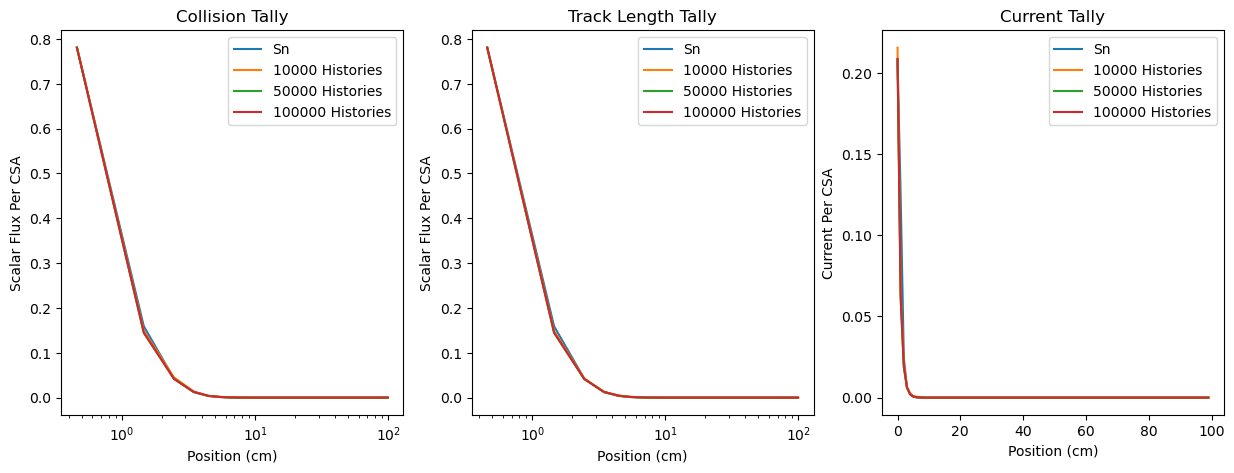

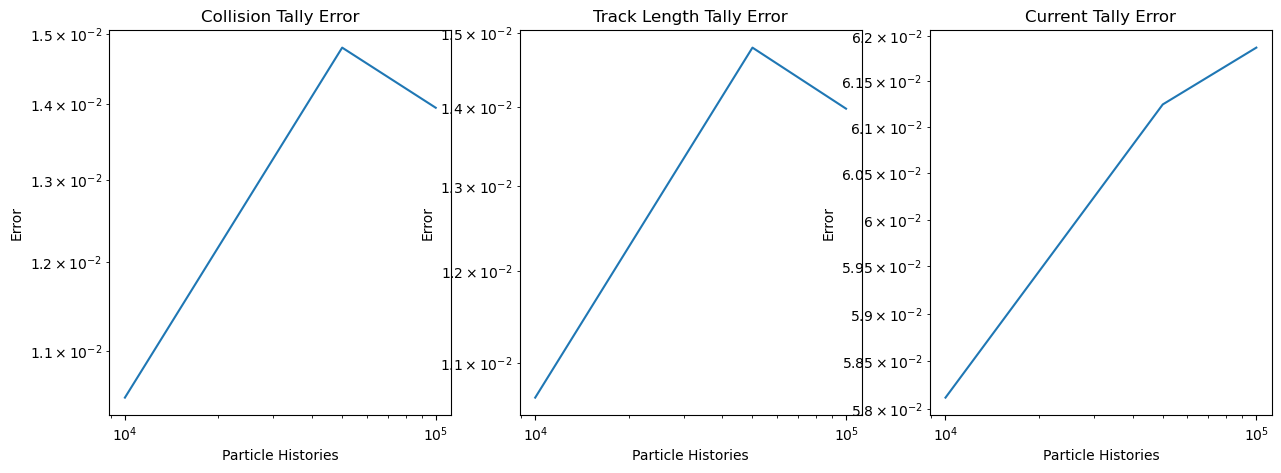

In [44]:
dx = problem_width / number_of_cells
x_avg_positions = [
    i * dx + - np.log((1 - np.exp(-dx /1))  / dx)
    for i in range(number_of_cells)
]
x_surface_positions = [i * dx for i in range(0, number_of_cells)]

analytical_solution = lambda x: np.exp(-sigma_t * x ) * sn_solver_flux[0]
analytical_solution_values = [analytical_solution(x) for x in x_avg_positions]

analytical_solution_current = lambda x: analytical_solution(x)
analytical_solution_current_values = [
    analytical_solution_current(x) for x in x_surface_positions
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig_error, axes_error = plt.subplots(1, 3, figsize=(15, 5))

for ax_n, ax_name in enumerate(["Collision", "Track Length"]):
    ax = axes[ax_n]
    ax_error = axes_error[ax_n]
    # ax.plot(x_avg_positions, analytical_solution_values, label="Analytical")
    ax.plot(x_avg_positions, sn_solver_flux, label="Sn")

    error_values = []
    for particle_history, result in solutions.items():
        result_values = result[ax_name] / result[ax_name][0] * sn_solver_flux[0]
        ax.plot(x_avg_positions, result_values, label=f"{particle_history} Histories")

        error = np.linalg.norm(result_values - sn_solver_flux)
        error_values.append(error)

    ax.set_xlabel("Position (cm)")
    ax.set_title(f"{ax_name} Tally")
    ax.set_ylabel("Scalar Flux Per CSA")
    ax.legend()
    ax.set_xscale("log")

    ax_error.plot(particle_histories, error_values)
    ax_error.set_xlabel("Particle Histories")
    ax_error.set_title(f"{ax_name} Tally Error")
    ax_error.set_ylabel("Error")
    ax_error.set_xscale("log")
    ax_error.set_yscale("log")

ax = axes[-1]
ax.plot(
    x_surface_positions, sn_solver_current, label="Sn"
)

error_values = []
for particle_history, result in solutions.items():
    result_values = result["Current"][1:]
    ax.plot(x_surface_positions, result_values, label=f"{particle_history} Histories")

    error = np.linalg.norm(result_values - sn_solver_current)
    error_values.append(error)

ax.set_xlabel("Position (cm)")
ax.set_title("Current Tally")
ax.set_ylabel("Current Per CSA")
ax.legend()
# ax.set_xscale("log")

ax_error = axes_error[-1]
ax_error.plot(particle_histories, error_values)
ax_error.set_xlabel("Particle Histories")
ax_error.set_title("Current Tally Error")
ax_error.set_ylabel("Error")
ax_error.set_xscale("log")
ax_error.set_yscale("log")